In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.transforms as mtransforms
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch, Rectangle
from matplotlib.offsetbox import DrawingArea
import warnings
from PIL import Image
import cv2
warnings.filterwarnings('ignore')

2024-10-15 14:08:39.211542: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 14:08:39.361910: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 14:08:39.410312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 14:08:39.492864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 14:08:39.510593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 14:08:39.604001: I tensorflow/core/platform/cpu_feature_gu

In [2]:
cluster = LocalCluster()  
# display(cluster)

In [3]:
path_data = "/data/keeling/a/alfonso8/gpm/camp2ex"
aircraft = 'Lear'
aircraft2 = 'Learjet'
store4 = f"{path_data}/cloud_probes/zarr/HVPS_{aircraft2}.zarr"
store8 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"

In [6]:
xr_hvps = xr.open_zarr(store4)
# xr_hvps = xr_hvps.where(xr_hvps.Temp > 2, drop=True)
xr_merg = xr.open_zarr(store8)
dt_camp2ex = xr.backends.api.open_datatree('../data/camp2ex_dtree.zarr', engine='zarr', consolidated=True)

In [7]:
diameter= np.arange(xr_hvps.diameter.min() / 1e3, xr_hvps.diameter.max() / 1e3, 0.1)
ad_xr = lambda d: 1.0048 + 0.0057 * d - 2.628 * d ** 2 + 3.682 * d ** 3 - \
                                                          1.677 * d ** 4
ad = ad_xr(diameter/10)
ad_hvps = ad_xr(xr_hvps.diameter/1e4)
_area = lambda x: np.pi * (x / 2) ** 2
area = _area(diameter)
area_hvps = _area(xr_hvps.diameter / 1e3)
area_corr = _area(diameter)

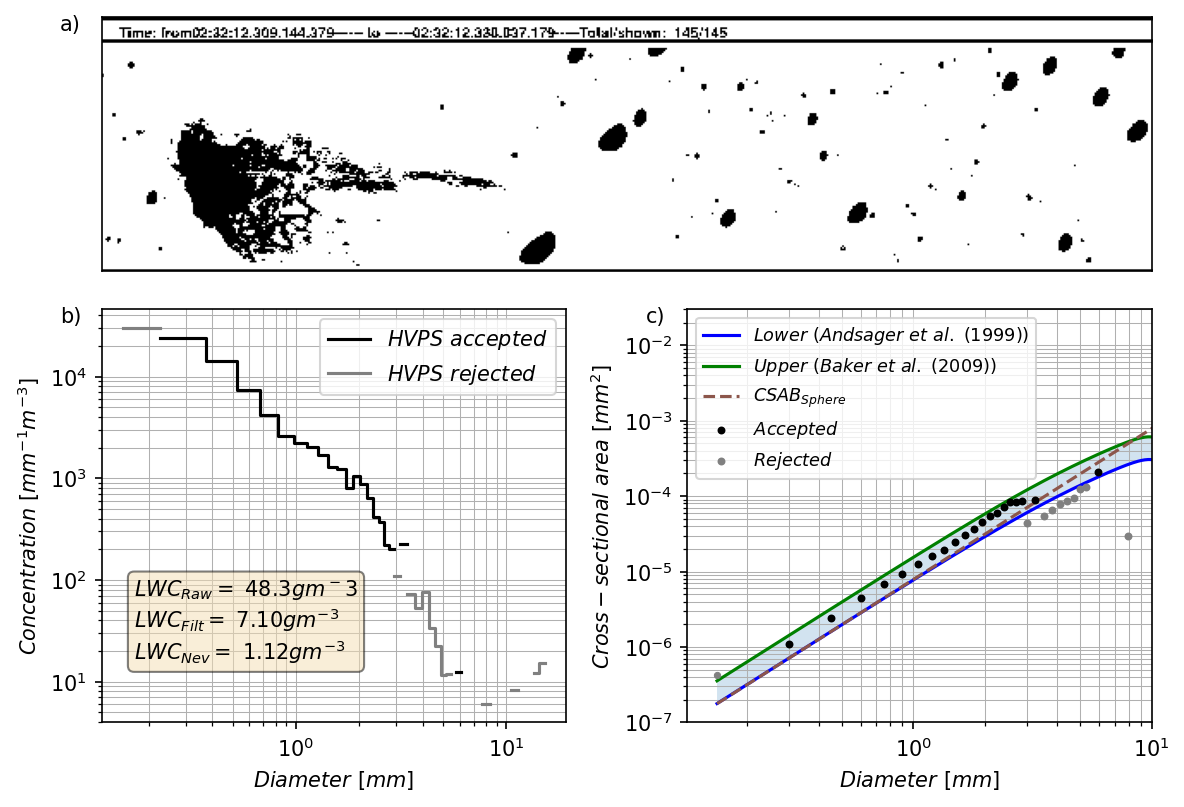

In [34]:
time='2019-09-07 02:32:12'
# fig, (ax1, ax) = plt.subplots(1, 2, figsize=(9, 4), dpi=150)
fig, axs = plt.subplot_mosaic([['a)', 'a)'], ['b)', 'c)']], figsize=(8,6), dpi=150)

path_img = '../data/CAMP2Ex_HVPS_P3B_V_20190907_023212_276415_RA.png'
img = np.asarray(Image.open(path_img))
ax0  = axs["a)"]
ax0.imshow(cv2.cvtColor(img[292:440, :], cv2.COLOR_BGR2RGB))
ax0.xaxis.set_tick_params(labelbottom=False)
ax0.yaxis.set_tick_params(labelleft=False)
ax0.set_xticks([])
ax0.set_yticks([])
# raw lwc

psd = (xr_hvps.sel(time='2019-09-07 02:32:12').psd * 1e6) 
d_D = xr_hvps.sel(time='2019-09-07 02:32:12').d_d
lwc_time =  (np.pi / (6*1000)) * psd * (xr_hvps.diameter/1e3) ** 3 * d_D / 1e3
lwc_text = lwc_time.sum('diameter').squeeze().values
lwc_filt = xr_merg.sel(time='2019-09-07 02:32:12').lwc.sel(diameter=slice(50, 3000)).sum().values
lwc_nev = xr_hvps.twc.sel(time='2019-09-07 02:32:12').values
acsa = xr_hvps.a_bin.sel(time=time) /  xr_hvps.cnt_bin.sel(time=time)
acsa_in = acsa.where(acsa >= area_hvps / 1e5 * ad_hvps).where(acsa <= area_hvps / 1e5 * ad_hvps * 2)
acsa_low = acsa.where(acsa < area_hvps / 1e5 * ad_hvps)
acsa_up = acsa.where(acsa > area_hvps / 1e5 * ad_hvps * 2)

y = xr_hvps.psd.sel(time=time) * 1e6
y = y.where(y > 0, np.nan)
yyes = y.where(acsa >= area_hvps / 1e5 * ad_hvps).where(acsa <= area_hvps / 1e5 * ad_hvps * 2)
ynot = y.where(acsa < area_hvps / 1e5 * ad_hvps)#.where(acsa > area_hvps / 1e5 * ad_hvps * 2)
ynot2 = y.where(acsa > area_hvps / 1e5 * ad_hvps * 2)

ax1 = axs['b)']
ax1.step(x=xr_hvps.diameter* 1e-3, y=yyes, where='mid', label='$HVPS \ accepted$', c='k')
ax1.step(x=xr_hvps.diameter* 1e-3, y=ynot, where='mid', c='grey', label='$HVPS \ rejected$')
ax1.step(x=xr_hvps.diameter* 1e-3, y=ynot2, where='mid', c='grey')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(which='both', lw=0.5)
ax1.set_ylabel('$Concentration \ [mm^{-1} m^{-3}]$')
ax1.set_xlabel('$Diameter \ [mm]$')
ax1.legend(fontsize=10)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax1.text(0.07, 0.35, "$LWC_{Raw}= \ $" + f'{lwc_text:.1f}' + f'$gm^{-3}$' + '\n' + 
         "$LWC_{Filt}=\  $" + f"{lwc_filt:.2f}" + '$gm^{-3}$' + '\n' +
         "$LWC_{Nev}=\  $" + f"{lwc_nev:.2f}" + '$gm^{-3}$',
        transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)

ax = axs['c)']

ax.plot(diameter,area/1e5 * ad, c='b', label='$Lower \ (Andsager \ et \  al. \ (1999))$')
ax.plot(diameter,area/1e5 * ad * 2, c='g', label='$Upper \  (Baker \  et \  al. \  (2009))$')
ax.plot(diameter , area/1e5,  color='tab:brown', ls='--', label='$CSAB_{Sphere}$')
ax.fill_between(diameter, 
                area/1e5 * ad , 
                area/1e5 * ad * 2, alpha=0.2)

ax.scatter(xr_hvps.diameter / 1e3, acsa_in, 
               zorder=2.5, c='k', lw=0.8, marker='.', label='$Accepted$')
ax.scatter(xr_hvps.diameter / 1e3, acsa_low, 
               zorder=2.5, c='gray', lw=0.8, marker='.', label='$Rejected$')
ax.scatter(xr_hvps.diameter / 1e3, acsa_up, 
               zorder=2.5, c='gray', lw=0.5, marker='.')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$Cross-sectional \ area \ [mm^2]$')
ax.set_xlabel('$Diameter \ [mm]$')
# title = f"{pd.to_datetime(xr_hvps.a_bin.sel(time=time).time.values): %Y-%m-%d %X} UTC - {aircraft}"
# fig.suptitle(title, fontsize=14, fontweight='bold', y=0.95)
ax.set_xlim(0, 10)
ax.set_xlim(0, 10)

ax.legend(loc='upper left', fontsize=8.5)
ax.grid(which='both', lw=0.5)
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-20/72, 1/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
fig.tight_layout()
plt.subplots_adjust(wspace=None, hspace=-0.1)
plt.savefig('../images/area_based_filter.svg', bbox_inches='tight')